#### Change the path if necessary.

In [1]:
import findspark
findspark.init('/home/peyman/spark-2.0.0-bin-hadoop2.7')

#### Let's import the libraries that we want to use.

In [2]:
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import desc
import time
import datetime
import pandas as pd

In [3]:
sc = SparkContext()

In [4]:
ssc = StreamingContext(sc,10)
sqlContext = SQLContext(sc)

In [5]:
ssc.checkpoint("The most popular Tweeter hashtag by track")

In [6]:
socket_stream = ssc.socketTextStream("127.0.0.1", 5593)

In [7]:
lines = socket_stream.window(30)

In [8]:
def aggregate_tags_count(new_values, total_sum):
    return sum(new_values) + (total_sum or 0)

In [9]:
from collections import namedtuple
fields = ("tag", "count" )
Tweet = namedtuple( 'Tweet', fields )

In [10]:
words = lines.flatMap(lambda text: text.split(" "))

wordsLowerCase = words.map(lambda word: word.lower())

hashtags = wordsLowerCase.filter(lambda word: word.startswith("#"))

hashtagsMapped = hashtags.map(lambda x: (x,1))

hashtagsMappedReduced = hashtagsMapped.reduceByKey(lambda x,y: x + y)

hashtagsMappedReducedUpdated = hashtagsMappedReduced.updateStateByKey(aggregate_tags_count)

TagCount = hashtagsMappedReducedUpdated.map(lambda rec: Tweet(rec[0], rec[1] ))

In [11]:
TagCount.foreachRDD(lambda rdd: rdd.toDF().sort(desc("count")).limit(10).registerTempTable("tweets"))

In [12]:
ssc.start()

In [13]:
time.sleep(30)

----------------------------------------------
2018-12-31 04:45:40.170954
----------------------------------------------


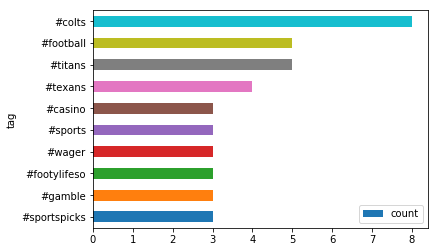

In [ ]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import sys
from IPython.display import clear_output
for i in range(100):
    print "----------------------------------------------"
    print str(datetime.datetime.utcnow())
    print "----------------------------------------------"
    df = sqlContext.sql("SELECT * FROM tweets ORDER BY count ASC").toPandas()
    df["count"] = pd.to_numeric(df["count"])    
    df.plot(x="tag", y="count", kind="barh")
    plt.pause(25)
    clear_output()